# Imports

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from patchify import patchify

# Create patchify dataset

In [83]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
import os
patch_dir = 'dataset_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [2]:
def extract_dish(img):
    # height, widh, center of image
    height, widh = img.shape[:2]
    center = (widh // 2, height // 2)

    # convert to grayscale for Otsu
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - widh/2, cy - height/2])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    margin = 20
    x0 = max(x - margin, 0)
    y0 = max(y - margin, 0)

    # crop
    side = min(w, h)
    x1 = x + side + margin
    y1 = y + side + margin
    extracted_img = img[y0:y1, x0:x1, :]

    # check crop is square
    assert extracted_img.shape[0] == extracted_img.shape[1], "Crop is not square!"
    return extracted_img, (y0, y1, x0, x1)

## padder from notebook 7

In [85]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

## create and save patches

In [86]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor):
    roots = ["Y2B_23", "Y2B_24"]

    for ds in roots:
        if ds == "Y2B_23":
            # images in subfolders "test", "train"
            image_dir = f"../Task_2/datasets/{ds}/images/{dataset_type}"
            images_path = sorted(glob.glob(f"{image_dir}/*.png"))
        else:
            # Y2B_24: images in one folder, filenames start with "train_" or "val_"
            img_root = f"../Task_2/datasets/{ds}/images"
            all_images = glob.glob(f"{img_root}/*.png")
            images_path = sorted(
                p for p in all_images
                if os.path.basename(p).startswith(f"{dataset_type}_")
            )

        mask_root = f"../Task_2/datasets/{ds}/masks"

        for image_path in images_path:
            base = os.path.basename(image_path)
            stem, _ = os.path.splitext(base)

            # find root mask path
            if ds == "Y2B_23":
                root_mask_path = os.path.join(mask_root, stem + "_root_mask.tif")
            else:
                root_candidates = glob.glob(os.path.join(mask_root, "*", stem + "_root_mask.tif"))
                if not root_candidates:
                    continue
                root_mask_path = root_candidates[0]

            if not os.path.exists(root_mask_path):
                print(f"Mask not found: {stem}_root_mask.tif")
                continue

            # open image and its root mask
            image = cv2.imread(image_path)
            root_mask = cv2.imread(root_mask_path, cv2.IMREAD_GRAYSCALE)
            
            # crop to petri dish - less computation in future
            image_cropped, (y0, y1, x0, x1) = extract_dish(image)
            root_cropped = root_mask[y0:y1, x0:x1]
            
            # pader - dimensions will be divisible by patch_size
            image_cropped = padder(image_cropped, patch_size)
            root_cropped = padder(root_cropped, patch_size)

            # scalaing (if needed)
            if scaling_factor != 1:
                image_cropped = cv2.resize(image_cropped, (0,0), fx=scaling_factor, fy=scaling_factor)
                root_cropped = cv2.resize(root_cropped, (0,0), fx=scaling_factor, fy=scaling_factor)

            # patchify image
            img_patches = patchify(image_cropped, (patch_size, patch_size, 3), step=patch_size)
            img_patches = img_patches.reshape(-1, patch_size, patch_size, 3)
            
            # patchify mask
            mask_patches = patchify(root_cropped, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # build paths for img/mask
            if dataset_type == 'train':
                img_subdir  = 'train_images/train'
                mask_subdir = 'train_masks/train'
            elif dataset_type == 'val':
                img_subdir  = 'val_images/val'
                mask_subdir = 'val_masks/val'
            else:
                raise ValueError(f"Unknown dataset_type: {dataset_type}")
            
            # base file name without extension, .png etc"
            base = os.path.basename(image_path)
            stem, _ = os.path.splitext(base)

            # base output paths (no index yet)
            image_patch_base = os.path.join(patch_dir, img_subdir, stem)
            mask_patch_base  = os.path.join(patch_dir, mask_subdir, stem + "_root_mask")
            

            for i, patch in enumerate(img_patches):
                out_path = f"{image_patch_base}_{i}.png"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)


            for i, patch in enumerate(mask_patches):
                out_path = f"{mask_patch_base}_{i}.tif"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)

Checking the most feasible size of patches

In [ ]:
2804/256

10.953125

In [89]:
patch_size = 256
scaling_factor = 1

create_and_save_patches('train', patch_size, scaling_factor)

Mask not found: 000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_root_mask.tif
Mask not found: 000_43-2-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected_root_mask.tif
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 98.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 99.0
Otsu algorithm selected the following threshold: 101.0
Mask not found: 008_43-17-ROOT1-2023-0

# Sanity check

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [147]:
img_paths = sorted(glob.glob("dataset_patched\\train_images\\train\\*.png"))
mask_paths = sorted(glob.glob("dataset_patched\\train_masks\\train\\*.tif"))

print(f"Number of images: {len(img_paths)}")
print(f"Number of masks: {len(mask_paths)}")

Number of images: 45859
Number of masks: 45859


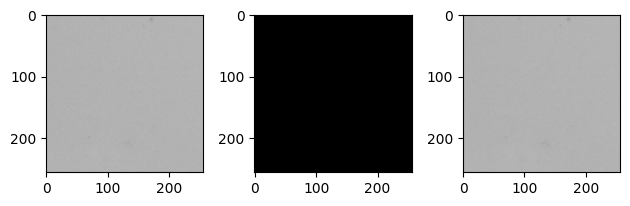

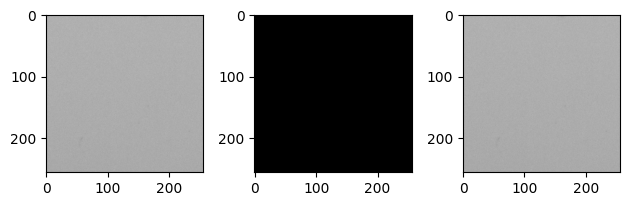

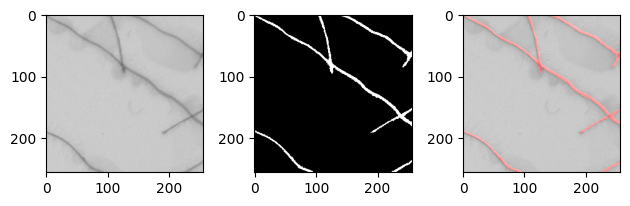

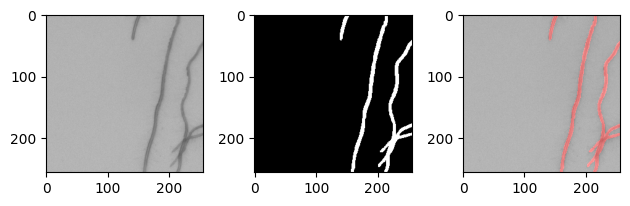

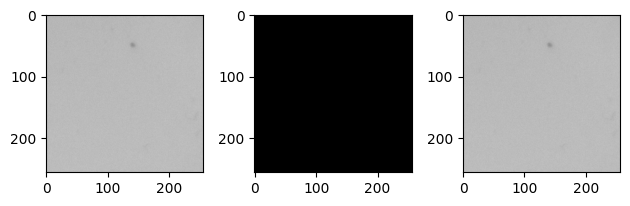

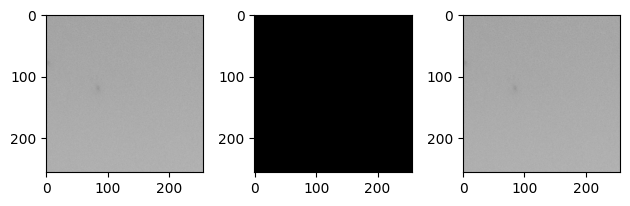

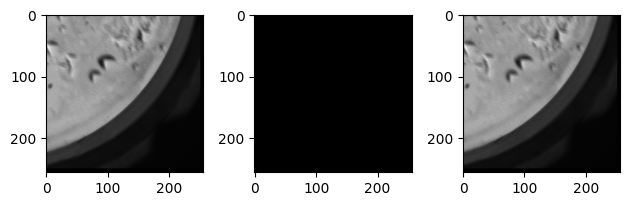

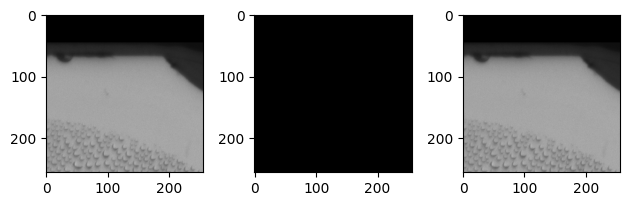

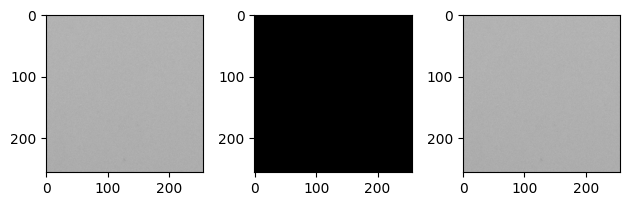

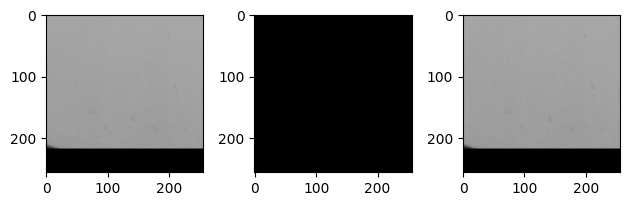

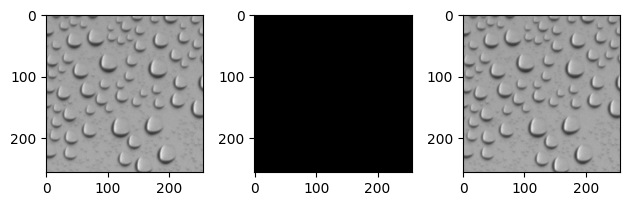

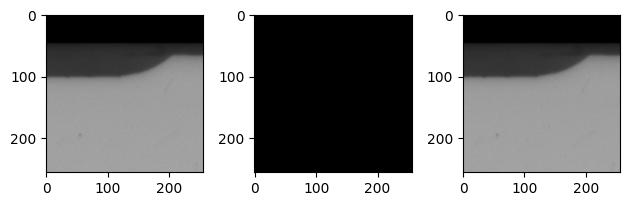

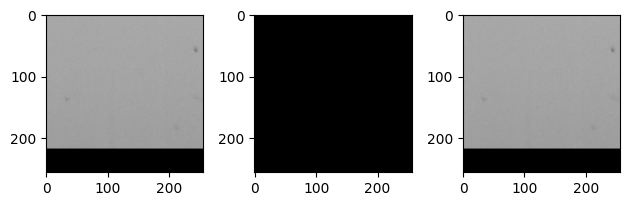

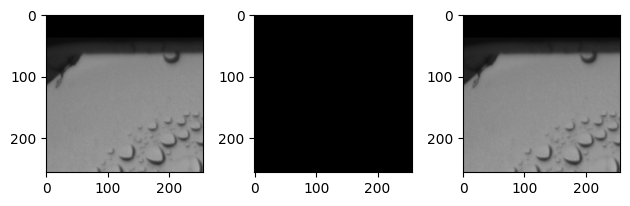

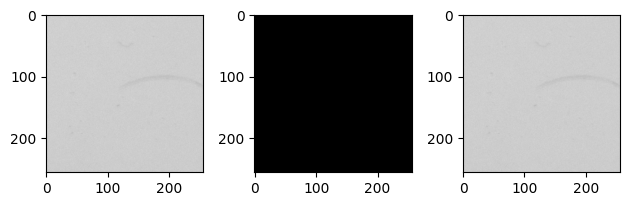

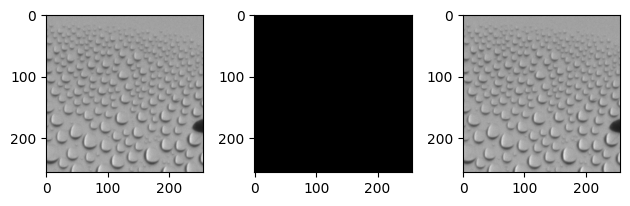

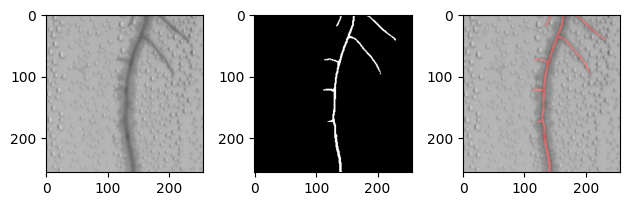

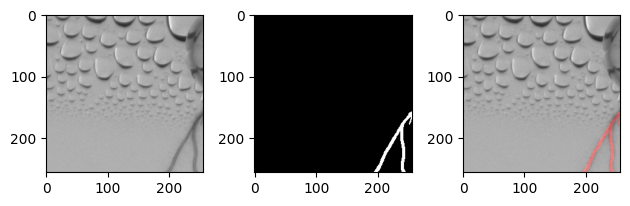

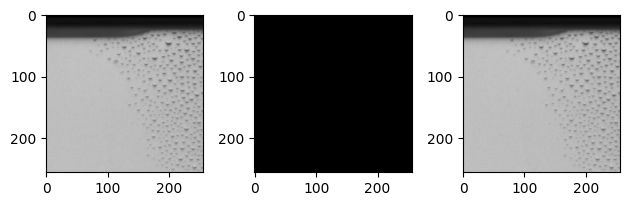

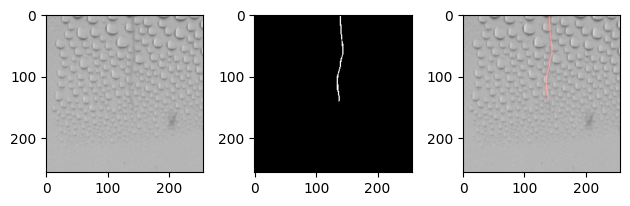

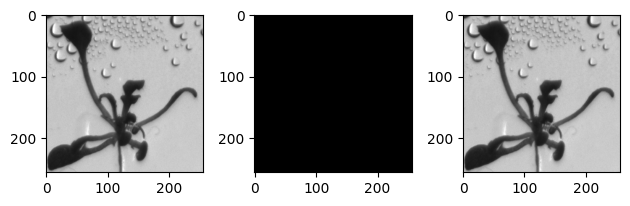

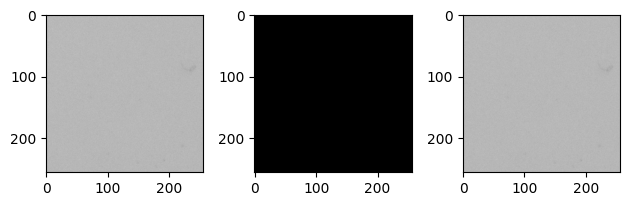

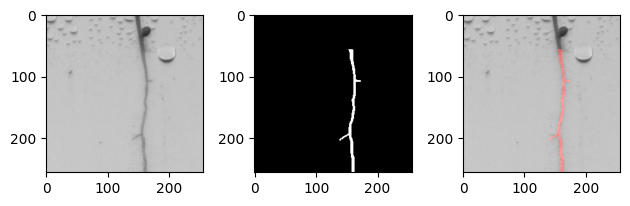

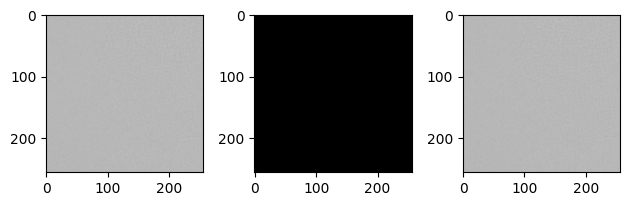

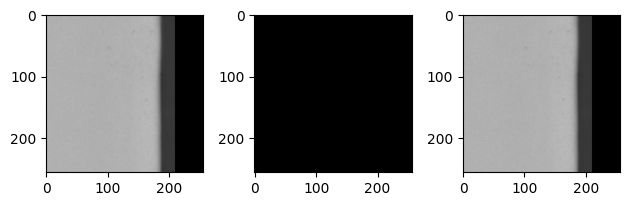

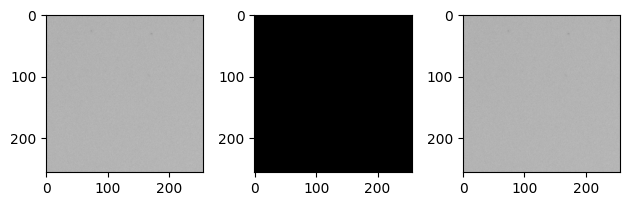

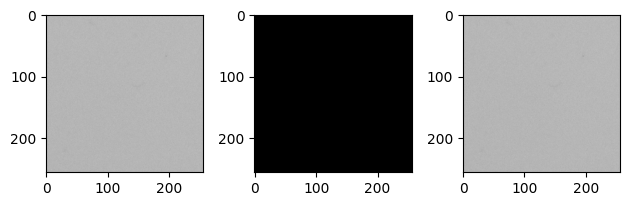

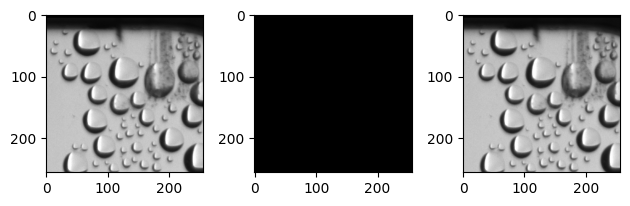

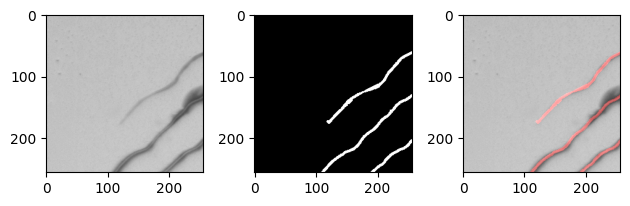

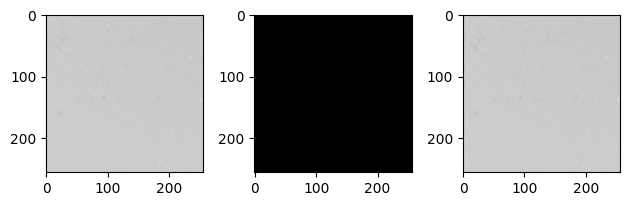

In [150]:
n = 30

indices = random.sample(range(len(img_paths)), k=min(n, len(img_paths)))

for i in indices:
    img_path = img_paths[i]
    mask_path = mask_paths[i]

    # read image and mask
    img = cv2.imread(img_path, 0)
    # Create an RGB version of the grayscale image
    im_rgb = np.dstack([img, img, img])

    root_mask = cv2.imread(mask_path, 0)

    # build red overlay where mask == 1
    root_color = [1, 0, 0]  # red
    overlay_root = np.zeros_like(im_rgb, dtype=float)

    # Transparency level
    alpha = 0.4

    overlay_root[root_mask == 1] = root_color

    # normalize image
    im_overlay = im_rgb / 255.0

    im_overlay += alpha * overlay_root
    im_overlay = np.clip(im_overlay, 0, 1)

    # plot
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(im_rgb)
    ax[1].imshow(root_mask, cmap='gray')
    ax[2].imshow(im_overlay)
    plt.tight_layout()
    plt.show()